In [22]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import defaultdict
import os
import warnings

from Preprocessing import preprocessing
from nltk import sent_tokenize, word_tokenize, pos_tag, download
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import pyLDAvis.gensim as gensimvis
import pyLDAvis

# gensim
from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

%matplotlib inline
warnings.filterwarnings(action='ignore')

### Import custom preprocessing function and view table of results

In [3]:
# delete output file if already exists
!rm data/processed/output_POS.txt

# call preprocessing to initiate preprocessing of all the books
preprocessing()

Done processing: Elephants Can Remember
Done processing: And Then There Were None
Done processing: Devices And Desires
Done processing: Cover Her Face
Done processing: Destination Unknown
Done processing: Jacksons Dilemma
Done processing: The Sandcastle
Done processing: Death Comes To Pemberley
Done processing: The Black Prince


In [4]:
#TODO add year for each book

book_df = pd.read_csv("data/processed/output_POS.txt", 
                           delimiter='|',
                           index_col=False,
                           quoting=3, 
                           encoding='utf-8')

print(book_df.shape)
book_df

(9, 72)


,Author,Title,book_order,total_words,avg_sentence_size,!,#,"""",%,$,...,VBD,VBG,VBP,VBN,WDT,VBZ,WRB,WP$,WP,Unnamed: 71
0,Agatha Christie,Elephants Can Remember,3,60026,11.163474,0.002634,0,0.284720,0,0.000000,...,0.063865,0.010610,0.039686,0.016994,0.003580,0.013776,0.005053,0.000052,0.009059,NaN
1,Agatha Christie,And Then There Were None,1,54108,9.090726,0.024591,0,0.185769,0,0.000062,...,0.073138,0.013511,0.017264,0.018840,0.001952,0.013285,0.003753,0.000030,0.005569,NaN
2,P.D. James,Devices And Desires,2,157218,14.983132,0.001079,0,0.165648,0,0.000000,...,0.066564,0.015928,0.021824,0.022531,0.003304,0.011203,0.005318,0.000094,0.004860,NaN
3,P.D. James,Cover Her Face,1,79347,13.633505,0.006820,0,0.153714,0,0.000000,...,0.073576,0.014477,0.015781,0.026823,0.003134,0.010517,0.004963,0.000145,0.005231,NaN
4,Agatha Christie,Destination Unknown,2,60478,10.253984,0.012498,0,0.282553,0,0.000000,...,0.060963,0.012452,0.029284,0.017914,0.002343,0.014655,0.004533,0.000038,0.005971,NaN
5,Iris Murdoch,Jacksons Dilemma,3,89939,17.450330,0.024277,0,0.189054,0,0.000000,...,0.074687,0.021951,0.013830,0.021275,0.002750,0.009363,0.006550,0.000082,0.005517,NaN
6,Iris Murdoch,The Sandcastle,1,115763,13.898787,0.012219,0,0.206783,0,0.000000,...,0.081775,0.018358,0.010258,0.020354,0.005265,0.007518,0.004006,0.000118,0.004109,NaN
7,P.D. James,Death Comes To Pemberley,3,90974,19.237471,0.001940,0,0.128828,0,0.000000,...,0.066433,0.014996,0.012163,0.032467,0.004970,0.009582,0.005656,0.000184,0.004506,NaN
8,Iris Murdoch,The Black Prince,2,137257,13.419730,0.010621,0,0.274566,0,0.000000,...,0.054606,0.017702,0.021827,0.017068,0.003288,0.016542,0.005219,0.000054,0.004914,NaN


In [5]:
# output csv for visualization in Tableau (Already completed)
# book_info_df.to_csv("data/processed/output_POS.csv")

In [6]:
# calculate the difference between the max and min ratios for each author
max_min_diff = []

authors = book_df['Author'].unique()
pos_cols = book_df.loc[:,'CC':'WP'].columns

for author in authors:
    pos_df = book_df[book_df['Author'] == author][pos_cols]

    for pos in pos_cols:
        max_min_diff.append((author, pos, pos_df[pos].max() - pos_df[pos].min()))
        

pos_diff_df = pd.DataFrame(max_min_diff, columns=['Author', 'POS', 'diff'])
pos_diff_df.head()

,Author,POS,diff
0,Agatha Christie,CC,0.008488
1,Agatha Christie,CD,0.005914
2,Agatha Christie,DT,0.017960
3,Agatha Christie,EX,0.001103
4,Agatha Christie,FW,0.000268


In [7]:
# get the top max differences that eahc aithor has in common 
james = (pos_diff_df[pos_diff_df['Author'] == 'P.D. James']
         .sort_values('diff', ascending=False)
         .head(14))
christie = (pos_diff_df[pos_diff_df['Author'] == 'Agatha Christie']
            .sort_values('diff', ascending=False)
            .head(14))
murdoch = (pos_diff_df[pos_diff_df['Author'] == 'Iris Murdoch']
           .sort_values('diff', ascending=False)
           .head(14))
top_pos = list(set(james['POS']).intersection(set(christie['POS'])).intersection(set(murdoch['POS'])))
top_pos

['IN', 'VB', 'DT', 'JJ', 'PRP', 'NN', 'VBP', 'VBD', 'RB']

In [8]:
book_df[top_pos + ['total_words']]

chi_df = pd.DataFrame(book_df[['Author', 'Title', 'book_order']])

for pos in top_pos:
    chi_df[pos] = book_df[pos]*book_df['total_words']
#     chi_df[pos] = book_df[pos]*100000

chi_df

,Author,Title,book_order,IN,VB,DT,JJ,PRP,NN,VBP,VBD,RB
0,Agatha Christie,Elephants Can Remember,3,4537.128454,2116.137190,3659.024605,3049.316456,5986.154946,5741.806260,2382.205758,3833.559381,3430.965832
1,Agatha Christie,And Then There Were None,1,4239.193743,1674.071336,4270.059687,2806.364128,4235.132435,5889.709490,934.100940,3957.338938,2881.092203
2,P.D. James,Devices And Desires,2,14895.774957,5463.202173,12470.139372,9943.060678,13486.206622,20268.987277,3431.067672,10465.001826,7657.318410
3,P.D. James,Cover Her Face,1,8123.018815,3160.180868,6154.874808,4509.740046,6347.795398,9848.684649,1252.213926,5838.060260,4304.430060
4,Agatha Christie,Destination Unknown,2,4822.685434,1814.185994,4413.800560,3646.852661,5021.352661,6351.961064,1771.064426,3686.894118,3301.110084
5,Iris Murdoch,Jacksons Dilemma,3,7147.796657,3166.391760,5991.825404,4223.772714,7943.091733,8957.750224,1243.880935,6717.285686,6457.664566
6,Iris Murdoch,The Sandcastle,1,11477.500070,4120.783967,9777.697995,5425.897797,8699.338103,13409.170833,1187.474569,9466.550674,6947.536064
7,P.D. James,Death Comes To Pemberley,3,9746.711664,3716.258170,7598.758421,4596.725490,5853.656360,11572.735797,1106.521368,6043.647310,4241.372046
8,Iris Murdoch,The Black Prince,2,11607.735483,5743.966378,9289.634766,7344.071297,13819.983105,15624.409115,2995.888749,7495.055557,9107.468975


In [ ]:
# chi_df.to_csv("data/processed/freq_POS.csv")

In [9]:
# calculate expected values for each book-author combo
def expected_vals(df):
    expected_dict = defaultdict(list)
    row_sums = df.sum(axis=1)
    col_sums = df.sum(axis=0)
    total = row_sums.sum()
    for pos, c in zip(df.columns, col_sums):
        for r in row_sums:
            expected_dict[pos] += [r*c/total]
    expt_df = pd.DataFrame(expected_dict)
    return expt_df

In [10]:
chi_squares = []

combinations = [[1,2], [1,3], [2,3]]
for author in authors:
    for combo in combinations:
        test_df = chi_df[(chi_df['Author'] == author) & (chi_df['book_order'].isin(combo))]
        chi = chisquare(f_obs=test_df[top_pos], 
                        f_exp=expected_vals(test_df[top_pos]), 
                        ddof=8, axis=None)
        print(f'Results for {author} books {combo[0]} and {combo[1]}:')
        print(f'Chi^2 statistic = {chi[0]}') 
        print(f'p-value = {chi[1]}\n')
        chi_squares.append(chi)

Results for Agatha Christie books 1 and 2:
Chi^2 statistic = 300.85922109638847
p-value = 1.7156440588128633e-59

Results for Agatha Christie books 1 and 3:
Chi^2 statistic = 880.1390669882994
p-value = 1.1758994758283995e-183

Results for Agatha Christie books 2 and 3:
Chi^2 statistic = 366.3150085556652
p-value = 2.0810457094236326e-73

Results for P.D. James books 1 and 2:
Chi^2 statistic = 303.70421651079147
p-value = 4.2742009182835334e-60

Results for P.D. James books 1 and 3:
Chi^2 statistic = 282.9740021571556
p-value = 1.0608146629495976e-55

Results for P.D. James books 2 and 3:
Chi^2 statistic = 910.8107223864869
p-value = 2.897724371776738e-190

Results for Iris Murdoch books 1 and 2:
Chi^2 statistic = 2197.6336482570273
p-value = 0.0

Results for Iris Murdoch books 1 and 3:
Chi^2 statistic = 768.1470221452238
p-value = 1.5232277639285088e-159

Results for Iris Murdoch books 2 and 3:
Chi^2 statistic = 807.9586655379997
p-value = 4.1151658984673806e-168



###  Word Analysis
* Did these authors have dementia and was it apparent in their writing? 

In [11]:
def get_word_count(sentences, name):
    count_vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b")
    doc_word = count_vectorizer.fit_transform(sentences).transpose()
    count_df = pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names())
    count_df['count'] = count_df.sum(axis=1)
    word_counts = count_df[['count']].reset_index()
    word_counts.columns = ['word', name+'_count']
    print(word_counts.shape)
    return word_counts.sort_values(name+'_count', ascending=False).reset_index(drop=True)

In [12]:
def get_book_content(book_file):
    with open("data/interim/" + book_file, 'r') as f:
        content = f.read().rstrip('\n')
#     sentences = sent_tokenize(content)
#     f.close()
    return sent_tokenize(content)

In [13]:
c1 = 'Christie1_AndThenThereWereNone.txt'
c2 = 'Christie2_DestinationUnknown.txt'
c3 = 'Christie3_ElephantsCanRemember.txt'
j1 = 'James1_CoverHerFace.txt'
j2 = 'James2_DevicesAndDesires.txt'
j3 = 'James3_DeathComesToPemberley.txt'
m1 = 'Murdoch1_TheSandcastle.txt'
m2 = 'Murdoch2_TheBlackPrince.txt'
m3 = 'Murdoch3_JacksonsDilemma.txt'

# get the word counts of each book as a dataframe
c1_count = get_word_count(get_book_content(c1), c1.split('_')[0])
c2_count = get_word_count(get_book_content(c2), c2.split('_')[0])
c3_count = get_word_count(get_book_content(c3), c3.split('_')[0])
j1_count = get_word_count(get_book_content(j1), j1.split('_')[0])
j2_count = get_word_count(get_book_content(j2), j2.split('_')[0])
j3_count = get_word_count(get_book_content(j3), j3.split('_')[0])
m1_count = get_word_count(get_book_content(m1), m1.split('_')[0])
m2_count = get_word_count(get_book_content(m2), m2.split('_')[0])
m3_count = get_word_count(get_book_content(m3), m3.split('_')[0])

(5084, 2)
(5827, 2)
(3961, 2)
(6648, 2)
(10552, 2)
(6950, 2)
(7964, 2)
(9408, 2)
(6315, 2)


In [14]:
book_counts = (c1_count.merge(c2_count, how='outer', on='word')
                       .merge(c3_count, how='outer', on='word')
                       .merge(j1_count, how='outer', on='word')
                       .merge(j2_count, how='outer', on='word')
                       .merge(j3_count, how='outer', on='word')
                       .merge(m1_count, how='outer', on='word')
                       .merge(m2_count, how='outer', on='word')
                       .merge(m3_count, how='outer', on='word'))

book_counts.fillna(0, inplace=True)
book_counts['word_length'] = book_counts['word'].apply(lambda x: len(x))

# reorder the columns 
cols = ['word', 'word_length', 'Christie1_count', 'Christie2_count', 
        'Christie3_count', 'James1_count', 'James2_count', 'James3_count', 
        'Murdoch1_count', 'Murdoch2_count', 'Murdoch3_count']
book_counts = book_counts[cols]
book_counts.head()

,word,word_length,Christie1_count,Christie2_count,Christie3_count,James1_count,James2_count,James3_count,Murdoch1_count,Murdoch2_count,Murdoch3_count
0,the,3,2646.0,2635.0,1717.0,3894.0,8614.0,5093.0,6553.0,4791.0,3699.0
1,of,2,1161.0,1292.0,1220.0,1808.0,3569.0,2099.0,2723.0,3169.0,1538.0
2,to,2,1154.0,1471.0,1629.0,2129.0,4252.0,2895.0,3335.0,3243.0,2301.0
3,he,2,1068.0,870.0,423.0,976.0,3237.0,1294.0,2569.0,807.0,2713.0
4,and,3,1066.0,1351.0,1376.0,2058.0,4365.0,3461.0,3170.0,3973.0,2513.0


In [ ]:
# book_counts.to_csv('data/processed/word_counts.csv')

## Unique words used per book

In [27]:
result = []
for book in book_counts.columns[2:]:
    count = 0
    for c in book_counts[book]:
        if c > 0:
            count += 1
    result.append((book, count))
    

In [28]:
result

[('Christie1_count', 5084),
 ('Christie2_count', 5827),
 ('Christie3_count', 3961),
 ('James1_count', 6648),
 ('James2_count', 10552),
 ('James3_count', 6950),
 ('Murdoch1_count', 7964),
 ('Murdoch2_count', 9408),
 ('Murdoch3_count', 6315)]

In [29]:
cristie_avg = (result[0][1] + result[1][1])/2
cristie_vocab_rate_of_change = (cristie_avg - result[2][1])/cristie_avg

james_avg = (result[3][1] + result[4][1])/2
james_vocab_rate_of_change = (james_avg - result[5][1])/james_avg

murdoch_avg = (result[6][1] + result[7][1])/2
murdoch_vocab_rate_of_change = (murdoch_avg - result[8][1])/murdoch_avg

print(f'Cristie vocabulary rate of change: {cristie_vocab_rate_of_change}')
print(f'James vocabulary rate of change: {james_vocab_rate_of_change}')
print(f'Murdoch vocabulary rate of change: {murdoch_vocab_rate_of_change}')

Cristie vocabulary rate of change: 0.27394372651452664
James vocabulary rate of change: 0.19186046511627908
Murdoch vocabulary rate of change: 0.272967994473866


In [15]:
book_counts[book_counts['word_length'] > 10].head()

,word,word_length,Christie1_count,Christie2_count,Christie3_count,James1_count,James2_count,James3_count,Murdoch1_count,Murdoch2_count,Murdoch3_count
436,thoughtfully,12,15.0,13.0,6.0,0.0,1.0,1.0,10.0,1.0,2.0
542,imagination,11,11.0,0.0,0.0,4.0,12.0,3.0,6.0,12.0,1.0
638,sticklehaven,12,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679,accusations,11,9.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
712,immediately,11,8.0,13.0,3.0,3.0,17.0,34.0,18.0,17.0,5.0


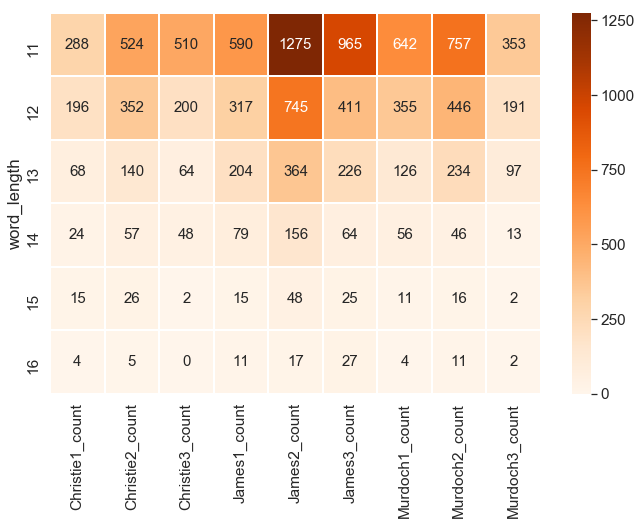

In [32]:
heat_df = (book_counts[(book_counts['word_length'] > 10) & 
                      (book_counts['word_length'] < 17)]
           .groupby('word_length')
           .sum())

sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(11,7))
sns.heatmap(heat_df, annot=True, ax=ax, fmt='g', 
            annot_kws={"size": 15}, cmap='Oranges', 
            linewidths=1, );

In [17]:
indef_pron = ['everyone', 'everything', 'everywhere', 'everybody' 
              'anywhere', 'anything', 'anyone', 'anybody' 
              'somewhere', 'someone', 'something', 'nobody', 
              'somebody', 'one', 'no one', 'another', 'either', 
              'neither', 'each', 'little', 'less', 'both', 'few', 
              'fewer', 'many', 'others', 'several', 'all', 'any', 
              'more', 'most', 'none', 'some']

book_counts[book_counts['word'].isin(indef_pron)]

,word,word_length,Christie1_count,Christie2_count,Christie3_count,James1_count,James2_count,James3_count,Murdoch1_count,Murdoch2_count,Murdoch3_count
19,all,3,299.0,325.0,263.0,0.0,437.0,176.0,346.0,673.0,433.0
21,one,3,282.0,238.0,374.0,283.0,451.0,206.0,334.0,421.0,199.0
59,little,6,130.0,123.0,57.0,128.0,135.0,66.0,142.0,219.0,144.0
65,some,4,120.0,100.0,212.0,101.0,155.0,183.0,227.0,309.0,256.0
88,any,3,95.0,98.0,121.0,115.0,170.0,134.0,138.0,202.0,79.0
114,more,4,76.0,114.0,104.0,153.0,323.0,176.0,190.0,238.0,157.0
136,something,9,60.0,56.0,206.0,56.0,106.0,58.0,124.0,209.0,128.0
163,anything,8,47.0,53.0,90.0,54.0,59.0,22.0,54.0,112.0,41.0
197,each,4,37.0,19.0,37.0,36.0,88.0,36.0,76.0,120.0,88.0
257,everything,10,26.0,31.0,23.0,18.0,34.0,8.0,38.0,88.0,41.0


In [ ]:
# TODO
# Visualize POS freq distributions Tableau
# Visualize the word counts Tableau
# decrease in noun to verb ratio

## LDA Topic Modeling

In [18]:
sentences = []
for book in os.listdir("data/interim"):
    book_file = str(book)
    with open("data/interim/" + book_file, 'r') as f:
        content = f.read().rstrip('\n')
    sentences += sent_tokenize(content)

In [19]:
stop_words = stopwords.words('english') + ['said']
count_vectorizer = CountVectorizer(ngram_range=(1, 3),  
                                   stop_words=stop_words, #'english', 
                                   token_pattern="\\b[a-z][a-z]+\\b")

# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.fit_transform(sentences).transpose()

f.close()
print(doc_word.shape)
pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()
# (35722, 6576)

(531140, 67213)


,0,1,2,3,4,5,6,7,8,9,...,67203,67204,67205,67206,67207,67208,67209,67210,67211,67212
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aa box,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aa box public,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaah rachel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

# get a list of vocabulary and pass to corpora dictionary
word_idx_list = list(count_vectorizer.vocabulary_.items())  
word_idx_list_sort = sorted(word_idx_list, key=lambda tup: tup[1])
word_list = [pair[0] for pair in word_idx_list_sort]

# corpora.Dictionary, corpora.MmCorpus
dictionary = corpora.Dictionary([word_list])

In [23]:
# Create lda model (equivalent to "fit" in sklearn)
lda_model = models.LdaModel(corpus=corpus, 
                              num_topics=9, 
                              update_every=5,
                              eval_every=10,
                              id2word=dictionary, 
                              passes=50, 
                              iterations=5000, 
                              random_state=np.random.RandomState(11))

In [24]:
topics_matrix = lda_model.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

for i, topics in topics_matrix[:,:]:
    print([word[0] for word in topics])

['like', 'time', 'love', 'would', 'one', 'know', 'could', 'perhaps', 'people', 'much', 'really', 'let', 'go', 'come', 'something', 'thought', 'way', 'think', 'back', 'never']
['would', 'see', 'think', 'felt', 'want', 'could', 'get', 'julian', 'must', 'mrs', 'like', 'go', 'going', 'make', 'need', 'leave', 'sort', 'come', 'may', 'soon']
['yes', 'oh', 'good', 'would', 'know', 'mrs', 'elizabeth', 'come', 'one', 'told', 'edward', 'back', 'man', 'knew', 'made', 'quite', 'thought', 'room', 'miss', 'came']
['could', 'priscilla', 'one', 'see', 'thought', 'donald', 'go', 'sorry', 'would', 'door', 'rosalind', 'felt', 'back', 'us', 'much', 'first', 'moment', 'even', 'mr', 'pain']
['know', 'would', 'right', 'course', 'one', 'please', 'last', 'night', 'mr', 'could', 'arms', 'take', 'time', 'never', 'sir', 'oh', 'wickham', 'got', 'find', 'dark']
['away', 'go', 'well', 'must', 'one', 'began', 'god', 'put', 'got', 'tim', 'might', 'think', 'little', 'hand', 'mind', 'mrs', 'could', 'mor', 'mean', 'oh']
[

In [25]:
vis_data1 = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data1) 

In [ ]:
# from gensim.sklearn_api import LdaTransformer # read about

# LDA(experiment w/num topics) into classifier -> lda_transformer 
# NMF? , pyLDAvis (visulaizing LDA), turi (topic model)


In [ ]:
# TODO 
# Check to see if results are statistically significant using amounts 
    # need the actual amounts to be able to compare them. 
    # apply a chi squared test and determine p-value
# The sentences/paragraphs be clustered visualize "clusters" 
# Visualize the sentiments through the book by sentence 
# Topic modeling? 
# Word2Vec? 